# Clipping to Reference Geographies of Interest

The goal of this notebook is to demonstrate how to use GADM shapefiles to clip model output to specific reference geographies of interest.

First:

```
# download files from S3
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/gadm_0.zip
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/gpw_v4_2pt5_min.nc.zip
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/sample.nc

# unzip gadm and gpw
unzip gadm_0.zip
unzip gpw_v4_2pt5_min.nc.zip

# remove zip files
rm *.zip
```

This assumes you have signed up for [GPW 4 access here](https://sedac.ciesin.columbia.edu/data/collection/gpw-v4).

The above shell commands will download and unzip a GADM shape file for countries of the world along with GPW population data and a sample NetCDF file based on the LPJmL model's output.

## Setup

You'll need to [install CDO](https://code.mpimet.mpg.de/projects/cdo/wiki#Installation-and-Supported-Platforms) before proceeding. Make sure to follow instructions for your specific OS.

### Requirements
```
numpy==1.20.3
geopandas==0.9.0
rioxarray==0.7.1
xarray==0.19.0
cdo==1.5.5
matplotlib==3.4.2
```

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

#### Load and examine the netCDF using xarray.

In [4]:
model_output = xr.open_dataset('sample.nc',decode_coords="all")
model_output = model_output.rio.write_crs(4326)

# Drop time variables; for some reason clipping these is problematic...
model_output = model_output[['harvested_area','harvest','production']]

#### Load and examine the GADM admin0 map dataset.

In [5]:
shapefile = 'gadm_0/gadm36_0.shp'
sf = gpd.read_file(shapefile)
sf.head()

,GID_0,NAME_0,geometry
0,ABW,Aruba,"POLYGON ((-69.97820 12.46986, -69.97847 12.469..."
1,AFG,Afghanistan,"POLYGON ((68.52644 31.75435, 68.53852 31.75457..."
2,AGO,Angola,"MULTIPOLYGON (((11.73347 -16.67255, 11.73347 -..."
3,AIA,Anguilla,"MULTIPOLYGON (((-63.42375 18.58903, -63.42375 ..."
4,ALA,Åland,"MULTIPOLYGON (((21.32195 59.74986, 21.32195 59..."


## Select countries of interest

Here we can select one or more countries of interest. In this case, let's select Ethiopia, Kenya, South Sudan, and Somalia.

> Note: the country names must match the names used in GADM

In [6]:
countries = ['Ethiopia','Kenya','South Sudan','Somalia']

In [7]:
countries_shp = sf[sf['NAME_0'].isin(countries)]

## Clip Model Output to Countries of Interest

In [8]:
model_output_c = model_output.rio.clip(countries_shp.geometry)

We can plot the before and after side by side to visually inspect it:

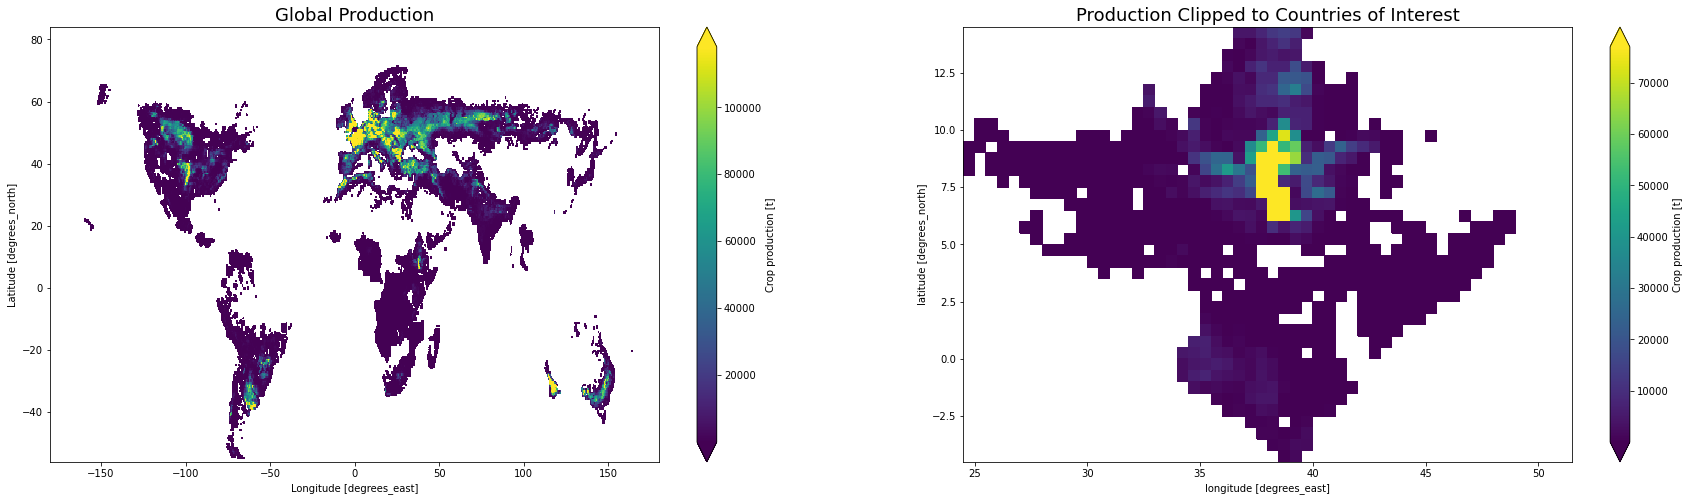

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 8))


model_output\
    .isel(crop=0, time=0)\
    ['production']\
    .plot(robust=True, ax=axes[0])
axes[0].set_title("Global Production", fontsize = 18)



model_output_c\
    .isel(crop=0, time=0)\
    ['production']\
    .plot(robust=True, ax=axes[1])
axes[1].set_title("Production Clipped to Countries of Interest", fontsize = 18)

print()